In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Url de los datos
df_ventas_compras = pd.read_csv('./Datos_Limpios/ventas_compras_productos.csv')
df_movimientos_inventario = pd.read_csv('./Datos_Limpios/movimientos_inventario_limpio.csv')
df_productos = pd.read_csv('./Datos_Limpios/productos_limpio.csv')

In [4]:
# Preprocesamiento de Datos:

# Tratar valores faltantes
ventas_clean = df_ventas_compras.fillna(method='ffill').fillna(method='bfill')

# Separar las transacciones de ventas y compras
ventas_df = ventas_clean[ventas_clean['Tipo'] == 'Venta'].copy()
compras_df = ventas_clean[ventas_clean['Tipo'] == 'Compra'].copy()

# Convertir las columnas de fechas
ventas_df['Posting Date'] = pd.to_datetime(ventas_df['Posting Date'])
compras_df['Posting Date'] = pd.to_datetime(compras_df['Posting Date'])

# Revisar los resultados de las primeras filas y la información de los DataFrames
# (ventas_df.head(), compras_df.head(), ventas_df.info(), compras_df.info())

# Añadir columnas de 'Month' y 'Year'
ventas_df['Month'] = ventas_df['Posting Date'].dt.month
ventas_df['Year'] = ventas_df['Posting Date'].dt.year
ventas_df['Day'] = ventas_df['Posting Date'].dt.day
compras_df['Month'] = compras_df['Posting Date'].dt.month
compras_df['Year'] = compras_df['Posting Date'].dt.year
compras_df['Day'] = compras_df['Posting Date'].dt.day

# Agrupar por mes y año y productos
ventas_por_mes_año = ventas_df.groupby(['Year', 'Month', 'No_']).size()
compras_por_mes_año = compras_df.groupby(['Year', 'Month', 'No_']).size()

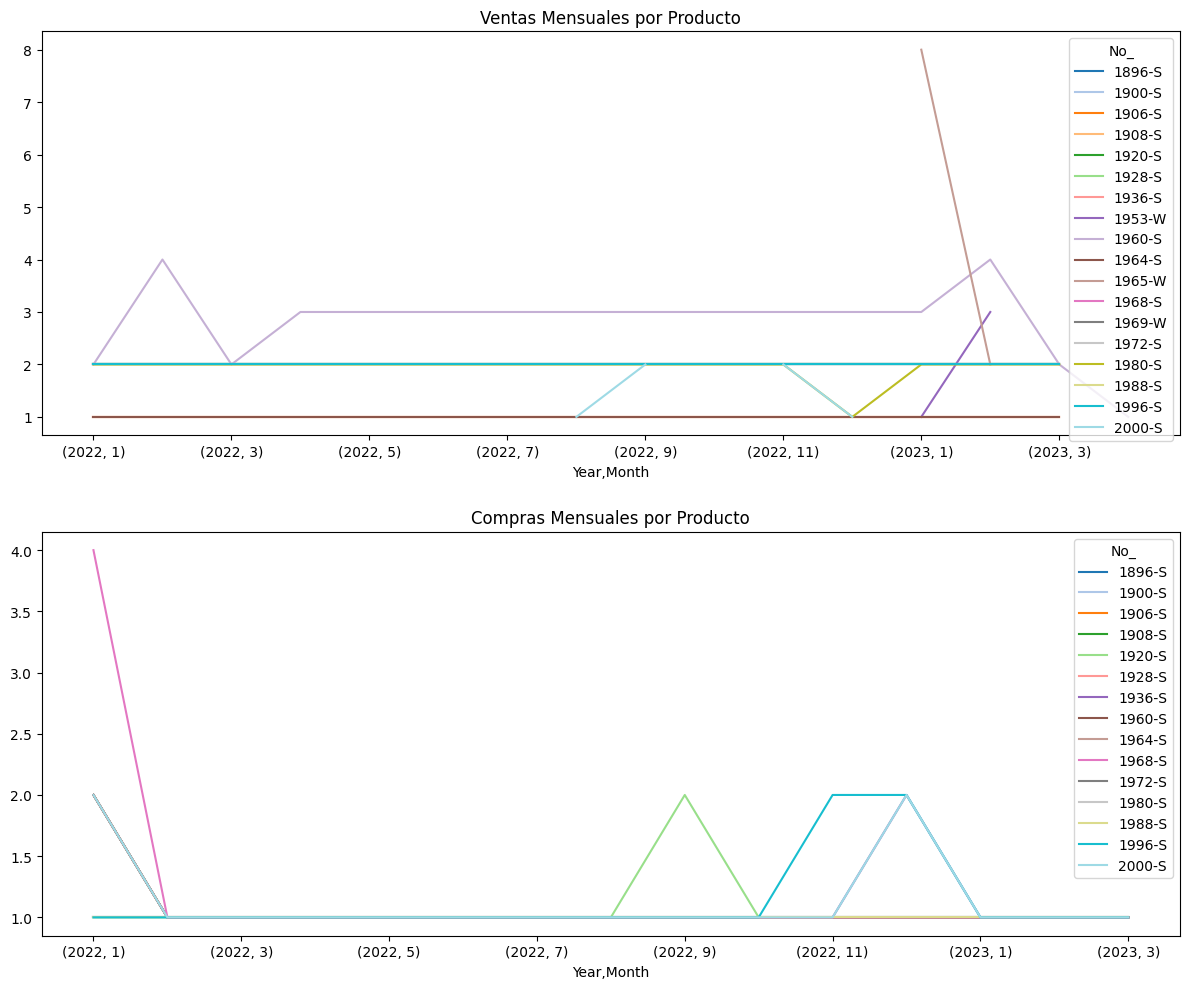

In [5]:
# Crear gráficos para visualizar las tendencias mensuales de ventas y compras por producto
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

ventas_por_mes_año.unstack().plot(ax=ax[0], title='Ventas Mensuales por Producto', colormap='tab20')
compras_por_mes_año.unstack().plot(ax=ax[1], title='Compras Mensuales por Producto', colormap='tab20')

plt.tight_layout()
plt.show()

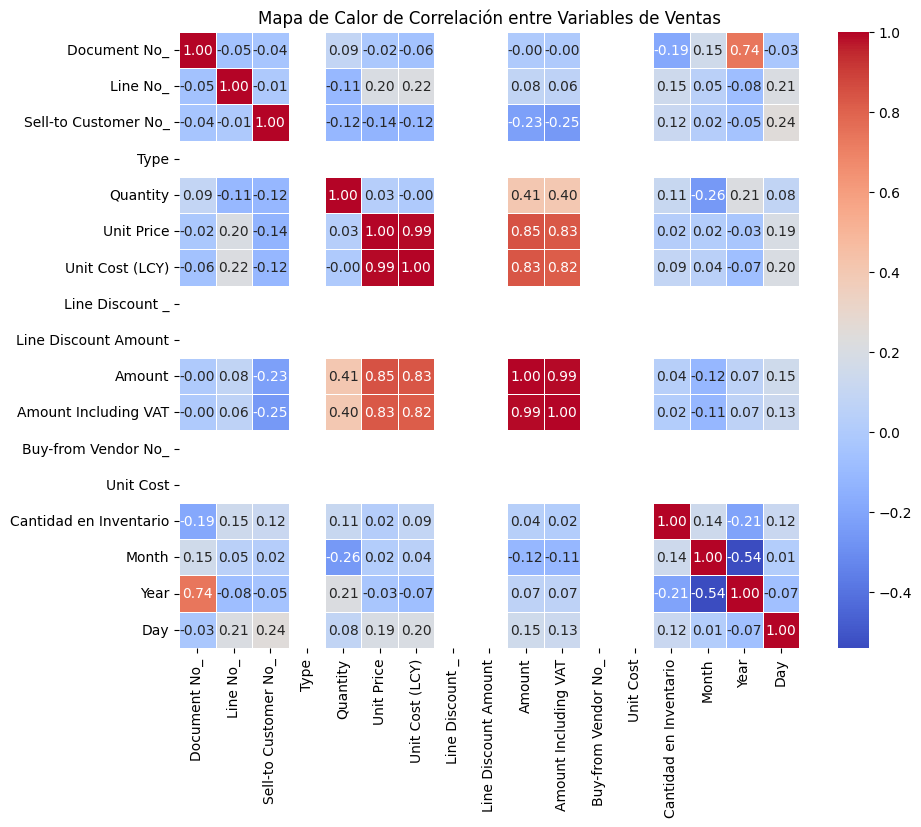

In [6]:
#Análisis de Correlación
# Seleccionar variables numéricas relevantes
correlaciones = ventas_df.corr()

# Crear un mapa de calor para visualizar las correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor de Correlación entre Variables de Ventas')
plt.show()

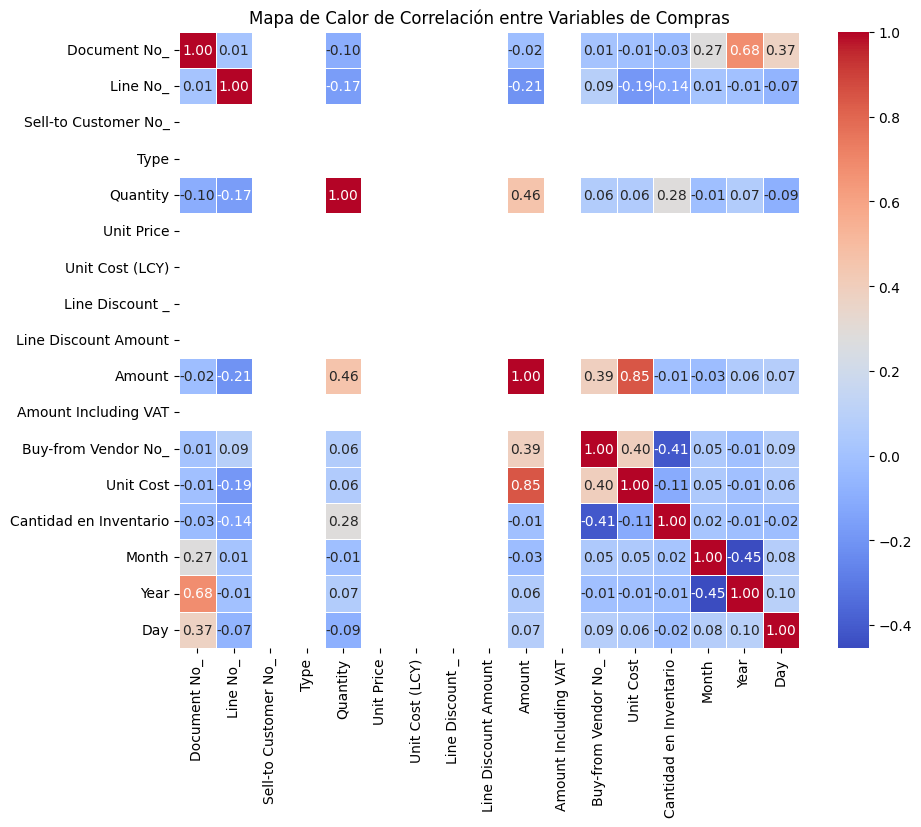

In [7]:
# Correlacion compras
correlaciones_compras = compras_df.corr()

# Crear un mapa de calor para visualizar las correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones_compras, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor de Correlación entre Variables de Compras')
plt.show()

In [8]:
# Identificar las variables más correlacionadas con la cantidad vendida
correlacion_cantidad = correlaciones['Quantity'].sort_values(ascending=False)
print('Correlación de Cantidad Vendida:')
print(correlacion_cantidad)

# Borrar las columnas sin correlación
# Type                           NaN
# Line Discount _                NaN
# Line Discount Amount           NaN
# Buy-from Vendor No_            NaN
# Unit Cost                      NaN

ventas_df = ventas_df.drop(['Type', 'Line Discount _', 'Line Discount Amount', 
                            'Buy-from Vendor No_', 'Unit Cost'], axis=1)

# Identificar las variables más correlacionadas con la cantidad comprada
correlacion_cantidad_compras = correlaciones_compras['Quantity'].sort_values(ascending=False)
print('Correlación de Cantidad Comprada:')
print(correlacion_cantidad_compras)

# Borrar las columnas sin correlación
# Sell-to Customer No_           NaN
# Type                           NaN
# Unit Price                     NaN
# Unit Cost (LCY)                NaN
# Line Discount _                NaN
# Line Discount Amount           NaN
# Amount Including VAT           NaN

compras_df = compras_df.drop(['Sell-to Customer No_', 'Type', 'Unit Price',
                                'Unit Cost (LCY)', 'Line Discount _', 'Line Discount Amount',
                                'Amount Including VAT'], axis=1)

Correlación de Cantidad Vendida:
Quantity                  1.000000
Amount                    0.407955
Amount Including VAT      0.403951
Year                      0.213889
Cantidad en Inventario    0.113033
Document No_              0.087758
Day                       0.080678
Unit Price                0.028123
Unit Cost (LCY)          -0.000399
Line No_                 -0.107965
Sell-to Customer No_     -0.117273
Month                    -0.255060
Type                           NaN
Line Discount _                NaN
Line Discount Amount           NaN
Buy-from Vendor No_            NaN
Unit Cost                      NaN
Name: Quantity, dtype: float64
Correlación de Cantidad Comprada:
Quantity                  1.000000
Amount                    0.456300
Cantidad en Inventario    0.282832
Year                      0.066696
Buy-from Vendor No_       0.064253
Unit Cost                 0.060480
Month                    -0.011297
Day                      -0.089293
Document No_             -0

In [9]:
# Revisar Variables para el modelo:
y_venta = ventas_df['Quantity']
y_compra = compras_df['Quantity']

# Seleccionar las variables para el modelo de ventas

X_venta = ventas_df[['Amount', 'Year', 'Cantidad en Inventario', 
                    'Day', 'Unit Price', 'No_', 'Month']].copy()

#Convertir las columnas categóricas en variables dummy
X_venta = pd.get_dummies(X_venta, columns=['No_'])

#Seleccionar las variables para el modelo de compras

X_compra = compras_df[['Amount', 'Cantidad en Inventario', 'No_',
                          'Unit Cost', 'Month', 'Day']].copy()

#Convertir las columnas categóricas en variables dummy
X_compra = pd.get_dummies(X_compra, columns=['No_'])

#guardar los datos limpios en Datos_Finales_Analisis
ventas_df.to_csv('./Datos_Finales_Analisis/ventas_df.csv', index=False)
compras_df.to_csv('./Datos_Finales_Analisis/compras_df.csv', index=False)


In [10]:
#Dividir los datos en conjuntos de entrenamiento y prueba, para ventas y compras
from sklearn.model_selection import train_test_split

X_train_venta, X_test_venta, y_train_venta, y_test_venta = train_test_split(X_venta, y_venta, test_size=0.2, random_state=42)
X_train_compra, X_test_compra, y_train_compra, y_test_compra = train_test_split(X_compra, y_compra, test_size=0.2, random_state=42)


In [11]:
# Crear un modelo de regresión lineal para predecir la cantidad vendida
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

modelo_venta = LinearRegression()
modelo_venta.fit(X_train_venta, y_train_venta)

y_pred_venta = modelo_venta.predict(X_test_venta)

# Calcular el error cuadrático medio
mse_venta = mean_squared_error(y_test_venta, y_pred_venta)
print('Error Cuadrático Medio para Ventas:', mse_venta)
print('R2 Score para Ventas:', r2_score(y_test_venta, y_pred_venta))

# Crear un modelo de regresión lineal para predecir la cantidad comprada
modelo_compra = LinearRegression()
modelo_compra.fit(X_train_compra, y_train_compra)

y_pred_compra = modelo_compra.predict(X_test_compra)

# Calcular el error cuadrático medio
mse_compra = mean_squared_error(y_test_compra, y_pred_compra)
print('Error Cuadrático Medio para Compras:', mse_compra)
print('R2 Score para Compras:', r2_score(y_test_compra, y_pred_compra))

Error Cuadrático Medio para Ventas: 4.049808973528348
R2 Score para Ventas: 0.6539269494475046
Error Cuadrático Medio para Compras: 9.543853930670721
R2 Score para Compras: -0.5006413416856847


In [12]:
# Crear un modelo de regresión SVR para predecir la cantidad vendida y comprada
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Crear un pipeline que incluye estandarización de los datos y el modelo SVR
modelo_venta_svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
modelo_compra_svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

# Entrenar el modelo SVR para ventas
modelo_venta_svr.fit(X_train_venta, y_train_venta)
y_pred_venta_svr = modelo_venta_svr.predict(X_test_venta)

# Calcular el error cuadrático medio y R² para el modelo de ventas
mse_venta_svr = mean_squared_error(y_test_venta, y_pred_venta_svr)
r2_venta_svr = r2_score(y_test_venta, y_pred_venta_svr)

# Entrenar el modelo SVR para compras
modelo_compra_svr.fit(X_train_compra, y_train_compra)
y_pred_compra_svr = modelo_compra_svr.predict(X_test_compra)

# Calcular el error cuadrático medio y R² para el modelo de compras
mse_compra_svr = mean_squared_error(y_test_compra, y_pred_compra_svr)
r2_compra_svr = r2_score(y_test_compra, y_pred_compra_svr)

# Imprimir los resultados para ambos modelos
print('SVR para Ventas - MSE:', mse_venta_svr, 'R²:', r2_venta_svr)
print('SVR para Compras - MSE:', mse_compra_svr, 'R²:', r2_compra_svr)

SVR para Ventas - MSE: 7.443395607119913 R²: 0.3639308320311321
SVR para Compras - MSE: 2.8309167907246042 R²: 0.5548768032397003


In [13]:
# Combinació en Cascada de Modelos
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

myseed = 42 # 42 es el valor de la semilla aleatoria, que se utiliza para reproducir los resultados

#Ventas:

# Fem la definició del model de arbre de decisió amb una profunditat de 3
arbre_decisio_cascade = DecisionTreeRegressor(max_depth=3, random_state=myseed)
arbre_decisio_cascade.fit(X_train_venta, y_train_venta)
prediccio_arbre_cascade = arbre_decisio_cascade.predict(X_test_venta)

# Fem la definició del model K-Neighbors Classifier amb 2 veïns
knn_cascade = KNeighborsRegressor(n_neighbors=2)
knn_cascade.fit(X_train_venta, y_train_venta)
prediccio_knn_cascade = knn_cascade.predict(X_test_venta)

# Fem la definició del model SVM amb un gamma de 0.07
svm_cascade = SVR(gamma=0.07)
svm_cascade.fit(X_train_venta, y_train_venta)
prediccio_svm_cascade = svm_cascade.predict(X_test_venta)

# Agrupem les prediccions dels classificadors base en una matriu
X_meta_cascade = np.column_stack((prediccio_arbre_cascade, prediccio_knn_cascade, prediccio_svm_cascade))

# Fem la combinació de les prediccions dels classificadors base amb les dades de prova
X_cascade = np.column_stack((X_test_venta, X_meta_cascade))

# Ara definim el metaclassificador Gradient Boosting amb 20 arbres i una profunditat de 3
meta_classifier_cascade = GradientBoostingRegressor(n_estimators=20, max_depth=3, random_state=myseed)

# Fem la validació creuada del metaclassificador amb les prediccions dels classificadors base i les dades originals:
cv_scores_cascade = cross_val_score(meta_classifier_cascade, X_cascade, y_test_venta, cv=5, scoring='accuracy')

# Fem el calcul de la mitjana i la desviació estàndard de la precisió:
mean_cv_score_cascade = cv_scores_cascade.mean()
std_cv_score_cascade = cv_scores_cascade.std()

print(f'Cascading Classifier - Validació Creuada (5-fold) - Precisió Mitjana: {mean_cv_score_cascade:.4f}, Desviació Estàndard: {std_cv_score_cascade:.4f}')

# Entrenem el metaclassificador amb les prediccions dels classificadors base i les dades originals:
meta_classifier_cascade.fit(X_cascade, y_test_venta)

# Fem la predicció del metaclassificador amb les dades de prova:
pred_meta_cascade = meta_classifier_cascade.predict(X_cascade)

# I fem el calcul de la precisió del metaclassificador:
test_accuracy_meta_cascade = meta_classifier_cascade.score(X_cascade, y_test_venta)

print(f'Cascading Classifier - Precisió sobre el Conjunt de Prova: {test_accuracy_meta_cascade:.4f}')

#Calcular r^2 para el modelo de ventas de cascada
r2_cascade = r2_score(y_test_venta, pred_meta_cascade)
print('R² para el modelo de ventas de cascada:', r2_cascade)
#error cuadrático medio para el modelo de ventas de cascada
mse_cascade = mean_squared_error(y_test_venta, pred_meta_cascade)
print('Error Cuadrático Medio para Ventas de Cascada:', mse_cascade)

#Compras:

# Fem la definició del model de arbre de decisió amb una profunditat de 3
arbre_decisio_cascade_compras = DecisionTreeRegressor(max_depth=3, random_state=myseed)
arbre_decisio_cascade_compras.fit(X_train_compra, y_train_compra)
prediccio_arbre_cascade_compras = arbre_decisio_cascade_compras.predict(X_test_compra)

# Fem la definició del model K-Neighbors Classifier amb 2 veïns
knn_cascade_compras = KNeighborsRegressor(n_neighbors=2)
knn_cascade_compras.fit(X_train_compra, y_train_compra)
prediccio_knn_cascade_compras = knn_cascade_compras.predict(X_test_compra)

# Fem la definició del model SVM amb un gamma de 0.07
svm_cascade_compras = SVR(gamma=0.07)
svm_cascade_compras.fit(X_train_compra, y_train_compra)
prediccio_svm_cascade_compras = svm_cascade_compras.predict(X_test_compra)

# Agrupem les prediccions dels classificadors base en una matriu
X_meta_cascade_compras = np.column_stack((prediccio_arbre_cascade_compras, prediccio_knn_cascade_compras, prediccio_svm_cascade_compras))

# Fem la combinació de les prediccions dels classificadors base amb les dades de prova
X_cascade_compras = np.column_stack((X_test_compra, X_meta_cascade_compras))

# Ara definim el metaclassificador Gradient Boosting amb 20 arbres i una profunditat de 3
meta_classifier_cascade_compras = GradientBoostingRegressor(n_estimators=20, max_depth=3, random_state=myseed)

# Fem la validació creuada del metaclassificador amb les prediccions dels classificadors base i les dades originals:
cv_scores_cascade_compras = cross_val_score(meta_classifier_cascade_compras, X_cascade_compras, y_test_compra, cv=5, scoring='accuracy')

# Fem el calcul de la mitjana i la desviació estàndard de la precisió:
mean_cv_score_cascade_compras = cv_scores_cascade_compras.mean()
std_cv_score_cascade_compras = cv_scores_cascade_compras.std()

print(f'Cascading Classifier - Validació Creuada (5-fold) - Precisió Mitjana: {mean_cv_score_cascade_compras:.4f}, Desviació Estàndard: {std_cv_score_cascade_compras:.4f}')

# Entrenem el metaclassificador amb les prediccions dels classificadors base i les dades originals:
meta_classifier_cascade_compras.fit(X_cascade_compras, y_test_compra)

# Fem la predicció del metaclassificador amb les dades de prova:
pred_meta_cascade_compras = meta_classifier_cascade_compras.predict(X_cascade_compras)

# I fem el calcul de la precisió del metaclassificador:
test_accuracy_meta_cascade_compras = meta_classifier_cascade_compras.score(X_cascade_compras, y_test_compra)

print(f'Cascading Classifier - Precisió sobre el Conjunt de Prova: {test_accuracy_meta_cascade_compras:.4f}')

#Calcular r^2 para el modelo de compras de cascada
r2_cascade_compras = r2_score(y_test_compra, pred_meta_cascade_compras)
print('R² para el modelo de compras de cascada:', r2_cascade_compras)
#error cuadrático medio para el modelo de compras de cascada
mse_cascade_compras = mean_squared_error(y_test_compra, pred_meta_cascade_compras)
print('Error Cuadrático Medio para Compras de Cascada:', mse_cascade_compras)


c:\Python310\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "c:\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "c:\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "c:\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 95, in _check_targets
    raise ValueError(
ValueError: Classification metrics

Cascading Classifier - Validació Creuada (5-fold) - Precisió Mitjana: nan, Desviació Estàndard: nan
Cascading Classifier - Precisió sobre el Conjunt de Prova: 0.9828
R² para el modelo de ventas de cascada: 0.9827867091112108
Error Cuadrático Medio para Ventas de Cascada: 0.20143302055471066
Cascading Classifier - Validació Creuada (5-fold) - Precisió Mitjana: nan, Desviació Estàndard: nan
Cascading Classifier - Precisió sobre el Conjunt de Prova: 0.9532
R² para el modelo de compras de cascada: 0.9532094290081871
Error Cuadrático Medio para Compras de Cascada: 0.29758101584547414


c:\Python310\lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "c:\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "c:\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 192, in wrapper
    return func(*args, **kwargs)
  File "c:\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 221, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "c:\Python310\lib\site-packages\sklearn\metrics\_classification.py", line 95, in _check_targets
    raise ValueError(
ValueError: Classification metrics

In [14]:
# Crear tabla de datos de los resultados
resultados = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'SVR', 'Cascada'],
    'Ventas': [r2_score(y_test_venta, y_pred_venta), r2_venta_svr, r2_cascade],
    'Compras': [r2_score(y_test_compra, y_pred_compra), r2_compra_svr, r2_cascade_compras]
})

# Guardar los resultados en un archivo CSV
resultados.to_csv('./resultados_modelos.csv', index=False)

# Visualizar los resultados
print(resultados)

             Modelo    Ventas   Compras
0  Regresión Lineal  0.653927 -0.500641
1               SVR  0.363931  0.554877
2           Cascada  0.982787  0.953209


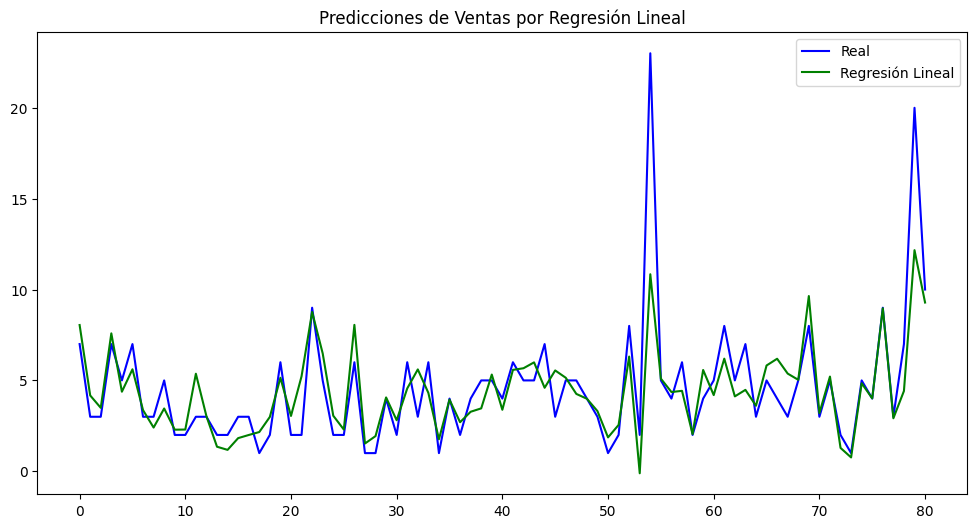

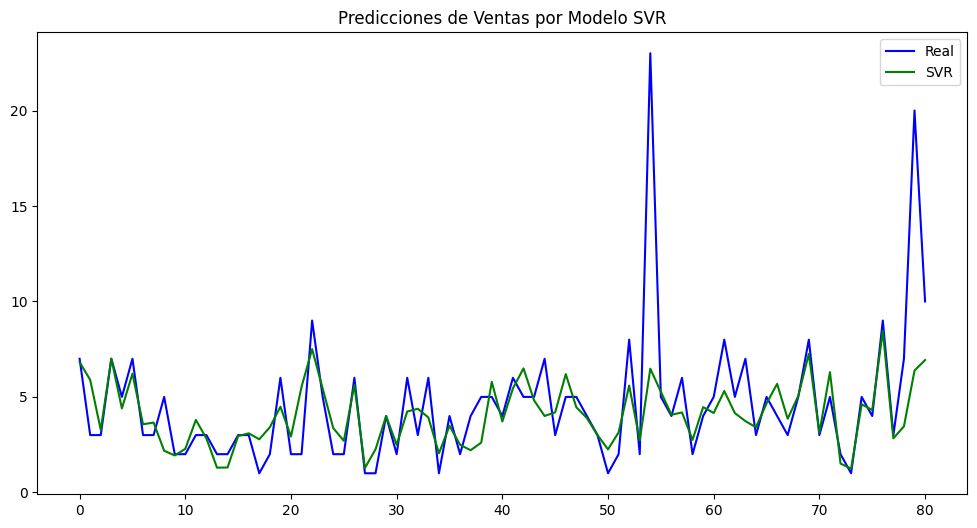

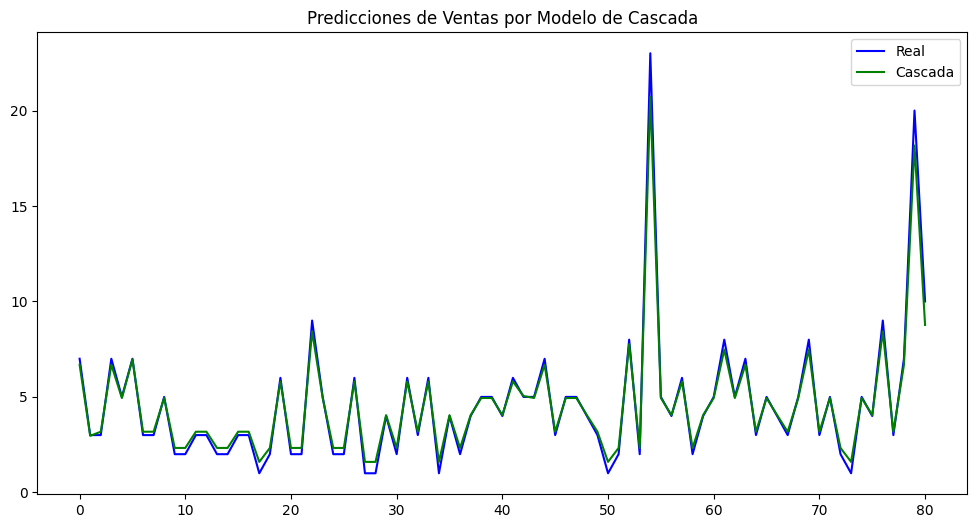

In [15]:
# Graficos de lineas de predicciones por modelo de ventas
plt.figure(figsize=(12, 6))
plt.plot(y_test_venta.values, label='Real', color='blue')
plt.plot(y_pred_venta, label='Regresión Lineal', color='green')
plt.title('Predicciones de Ventas por Regresión Lineal')
plt.legend()

# Graficos de lineas de predicciones por modelo de ventas de SVR
plt.figure(figsize=(12, 6))
plt.plot(y_test_venta.values, label='Real', color='blue')
plt.plot(y_pred_venta_svr, label='SVR', color='green')
plt.title('Predicciones de Ventas por Modelo SVR')
plt.legend()

# Graficos de lineas de predicciones por modelo de ventas de cascada
plt.figure(figsize=(12, 6))
plt.plot(y_test_venta.values, label='Real', color='blue')
plt.plot(pred_meta_cascade, label='Cascada', color='green')
plt.title('Predicciones de Ventas por Modelo de Cascada')
plt.legend()

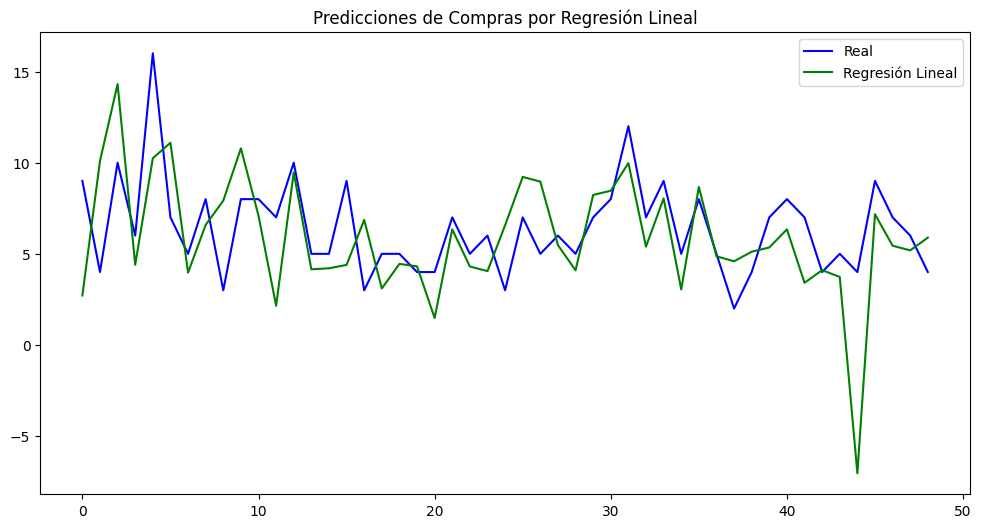

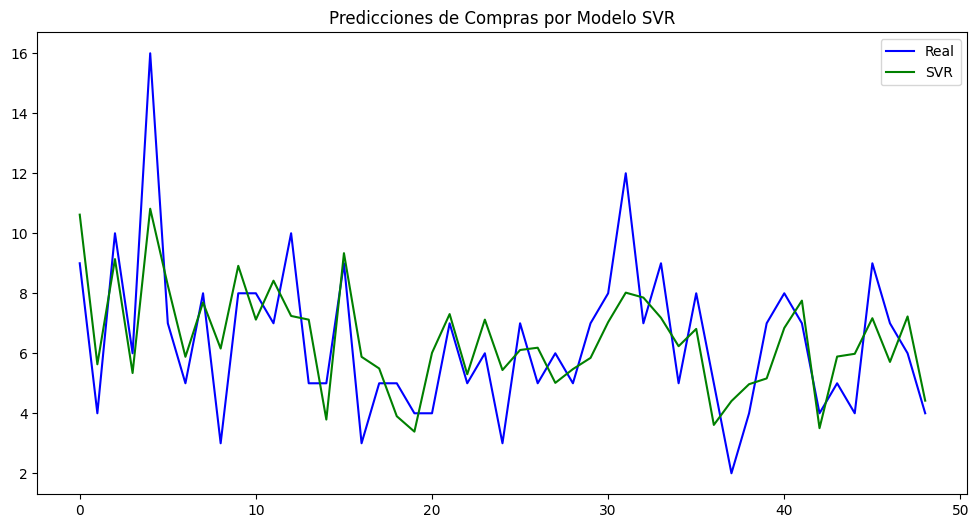

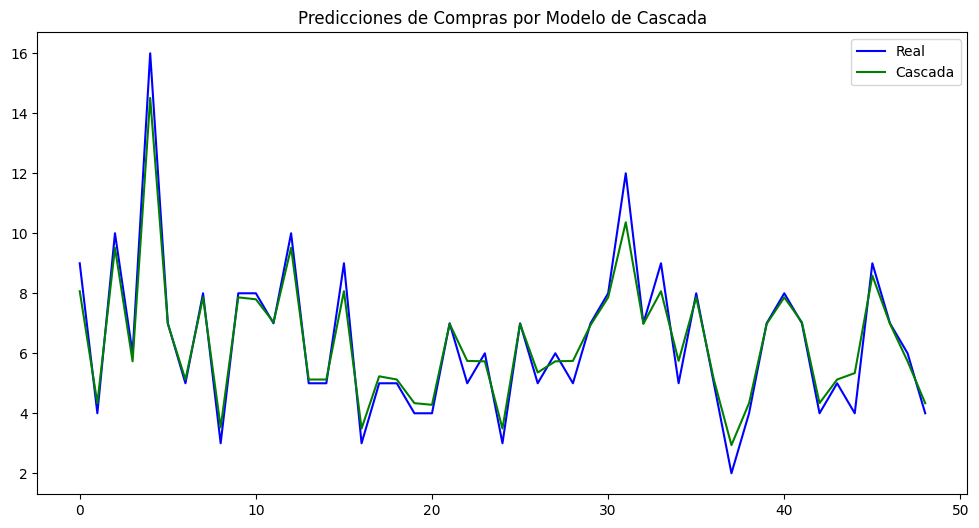

In [16]:
# Graficos de lineas de predicciones por modelo de compras
plt.figure(figsize=(12, 6))
plt.plot(y_test_compra.values, label='Real', color='blue')
plt.plot(y_pred_compra, label='Regresión Lineal', color='green')
plt.title('Predicciones de Compras por Regresión Lineal')
plt.legend()

# Graficos de lineas de predicciones por modelo de compras de SVR
plt.figure(figsize=(12, 6))
plt.plot(y_test_compra.values, label='Real', color='blue')
plt.plot(y_pred_compra_svr, label='SVR', color='green')
plt.title('Predicciones de Compras por Modelo SVR')
plt.legend()

# Graficos de lineas de predicciones por modelo de compras de cascada
plt.figure(figsize=(12, 6))
plt.plot(y_test_compra.values, label='Real', color='blue')
plt.plot(pred_meta_cascade_compras, label='Cascada', color='green')
plt.title('Predicciones de Compras por Modelo de Cascada')
plt.legend()

plt.show()